# Sparse Method Algorithm for Research of Transcients Signal

Find transient source in data cubes

F. Acero, T. Stolarczyk, A. Chalumeau, Juin 2018

This notebook will:
1. Simulation (generate_cube_simu)
    - generate the fake data cubes (X,Y,T)
    - Filter the noise in the cubes with different methods
    - Find the peak (burst) in the data
    - Measure how well the methods performed
2. Produce diagnostic and result plots (plot_slice)

3. Produce performance plots based on Monte-Carlo

Some scenarios are considered: 
1. Transcient source position known:
    - Appearing in the FoV : known background
    - Generalist case : background evaluated online
2. Unknown position:
    - Wavelet cleaning

All the code is pure Python with the exception of the denoising step which requires the binary file msvst_2d1d.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
#from matplotlib.colors import Normalize

from gammapy.stats import significance

from astropy.convolution import convolve,convolve_fft,Gaussian1DKernel,Gaussian2DKernel,Tophat2DKernel
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord,Angle
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table

from scipy.stats import norm
from scipy import interpolate
from scipy.ndimage import zoom

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
import os,subprocess,sys,getpass,copy
import time as systime
import multiprocessing as mp
from functools import partial
from collections import defaultdict

#import line_profiler
#%load_ext line_profiler
#from scipy.stats import chisqprob
#from scipy.special import erfinv,erf,erfcx

import smartcube as smart

In [10]:
### Styles
# Define some plotting parameters and styles
#print(plt.style.available)
#plt.style.use('seaborn-talk')
plt.style.use('ggplot')

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
#### Global variables and initialisations
# Path to the binary file - This is lame and adding the binary file to somewhere accesible by $PATH shoud be enough.
#prog='/Users/facero/Documents/Work/CTA/CTA-AIM/code/image-cleaning/msvst/build/msvst_2d1d'

user = getpass.getuser()
print("Defining variables for user",user)
exit
if (user=="achalume"):
    root_dir   = "/Users/achalume/Documents/Stage/Codes/" 
    bin_dir    = "/Users/achalume/Documents/Lib_files/Sparse2D/build/"
elif (user=="stolar"):
    root_dir   = "/home/stolar/Code/" 
    bin_dir    = root_dir + "bin/"

input_dir  = root_dir + "GRB-Fermi/FAWT3D/FermiData/"
output_dir = root_dir + "GRB-Fermi/FAWT3D/output/"
msvst      = bin_dir  + "msvst_2d1d"
score_dir  = root_dir + "GRB-Fermi/FAWT3D/scores/"
fig_dir    = root_dir + "GRB-Fermi/FAWT3D/Figures/"

#### Check existences
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
if not os.path.exists(fig_dir) :
    os.makedirs(fig_dir)
if not os.path.exists(score_dir) :
    os.makedirs(score_dir)
    
print("Directories :")
print("    - Root              :",root_dir)
print("    - MSVST_2d1d binary :",bin_dir)
print("    - Input             :",input_dir)
print("    - Output            :",output_dir)
print("    - Scores            :",score_dir)
print("    - Figures           :",fig_dir)

Defining variables for user Stolar


NameError: name 'root_dir' is not defined

# LC function

In [ ]:
def LCBinChange(pre_t,pre_LC,fact_T_bin):
    """
    Re-bin a light curve multiplying the initial bin size with fact_T_bin. Returns : new_t,new_LC
    """
    
    alpha = fact_T_bin
    new_t = np.zeros(int(len(pre_t)/alpha)) ; new_LC = np.zeros(len(new_t))
    for i in range(0,len(new_t)):
        new_t[i] = pre_t[int(i*alpha)]
        new_LC[i] = np.sum(pre_LC[int((alpha*i)):int((alpha*i)+alpha)])
   
    return new_t,new_LC

############################################
def NormLC(LC,value,time,tmin,tmax):
    """
    Norm a range in a light curve (SUM(LC) = value from tmin to tmax). Returns : Normed_LC
    """
    
    LC_range = LC[np.where((time>=tmin) & (time<=tmax))]
    Norm_range_LC = value * (LC_range/np.sum(LC_range))

    for i in range(0,len(LC_range)) : 
        if LC_range[i]!=0 : LC_val = LC_range[i] ; step = i ; break # choose the first non null arg

    Totalfactor = Norm_range_LC[step]/LC_val

    Normed_LC = Totalfactor * LC
    
    return Normed_LC

############################################
def InterpFunction(x_val,y_val,x_val_new):
    """
    Interpolate y(x) to get an approached function (y_new) with a given xtable (x_val_new). Returns : y_new
    """
    
    f = interpolate.interp1d(x_val,y_val)
    y_new = f(x_val_new)
    
    return y_new

############################################
def MakeLCTh(timebin,Xi,Tmintot,Tmaxtot,Ntotrange,Tminrange,Tmaxrange):
    """
    Make the theoretical LC normalizing at Ntotrange from Tminrange to Tmaxrange. Returns : Time, LC
    """
    
    T_0 = Tmintot
    Time = np.arange(Tmintot,Tmaxtot+timebin,timebin)
    K = (T_0**Xi) * (1+Xi) / (Tmaxtot**(1+Xi) - Tmintot**(1+Xi))
    LC = K * (Time/T_0)**Xi
    
    LC_norm = NormLC(LC,Ntotrange,Time,Tminrange,Tmaxrange)
    
    return Time,LC_norm

############################################
def MakeLCFa(datafile,Timebin,Bin_Factor,Ntotrange,Tminrange,Tmaxrange):
    """
    From Fabio's file, make LC normalizing at Ntotrange from Tminrange to Tmaxrange\
    choosing an initial bin size (Timebin). Returns : Time,LC
    """
    
    TimeData,LCData = np.loadtxt(datafile,unpack=True)
    Time = TimeData - TimeData[0] ; Time_size = TimeData[-1] - TimeData[0]   
    
    # Decrease time bin using an interpolation
    TimeInterp  = [x*Timebin for x in range(0,int(Time_size/Timebin),1)]
    TimeInterp = np.array(TimeInterp)
    LC = InterpFunction(Time,LCData,TimeInterp)
    
    LC_norm = NormLC(LC,Ntotrange,TimeInterp,Tminrange,Tmaxrange)
    T_input,LC_input = LCBinChange(TimeInterp,LC_norm,Bin_Factor) 
    
    return T_input,LC_input

############################################
def MakeLCIn(datafile,Timebin,Bin_Factor,Ntotrange,Tminrange,Tmaxrange):
    """
    From Inoue's extrapolated LC, make LC normalizing at Ntotrange from Tminrange to Tmaxrange.\
    Initial time bin (0.5) taken from the article. Returns : Time, LC
    """
    
    TData,LCData = np.genfromtxt(datafile,unpack=True,skip_header=6)

    # Set time values
    TData_0 = round(TData[0]) ; TData_end = np.round(TData[-1]/Timebin)*(Timebin)
    Time = np.linspace(TData_0,TData_end,len(TData))
    # Set LC values
    LC = LCData * Timebin # Put light curve in counts (it was in Cts/Bin before)
    LC = np.rint(LC).astype(int) # Set counts values

    LC_norm = NormLC(LC,Ntotrange,Time,Tminrange,Tmaxrange)
    T_input,LC_input = LCBinChange(Time,LC_norm,Bin_Factor)

    return T_input,LC_input

# Cube fonctions

In [ ]:
def BkgCube(time,SteadSrcPeak,bkg):
    """
    Creates the background model cube from a background value and a steady source peak.\
    Returns : BkgCube
    """
    BkgToycube = smart.CreateBkgModelCube(time,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,sigma_vignetting,pixelsize)
    BkgCube = smart.NoiseCube(BkgToycube)
    
    return BkgCube

############################################
def ImageCube(LC,time,SrcPeak,xcent,ycent,SteadSrcPeak,bkg):
    """
    Creates a cube containing bkg + transcient source. Returns : Cube 
    """
    
    BkgToycube = smart.CreateBkgModelCube(time,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,sigma_vignetting,pixelsize)    
    
    #Create cubes' lists
    SrcCube = smart.CreateSignalModelCube(LC,SrcPeak,xcent,ycent,sigmaX,sigmaY,n2Dsize,sigma_vignetting,pixelsize)
    NoisyCube = smart.NoiseCube(SrcCube+BkgToycube)
    
    return NoisyCube

############################################
def BkgModelCube(time,tmin,tmax,tbin,SteadSrcPeak,bkg):
    """
    Create a bkg model cube (size = time) containing at each timebin the same image corresponding\
    to an evaluated bkg estimated from tmin to tmax (with tbin).Returns : BkgModelCube
    """
    
    TimeAccum = np.arange(tmin,tmax+1,tbin)

    BkgToycube = smart.CreateBkgModelCube(TimeAccum,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,sigma_vignetting,pixelsize)
    BkgNoisyCube = smart.NoiseCube(BkgToycube)
    BkgMeanImage = smart.CumulCube(BkgNoisyCube)[:,:,-1]/(len(TimeAccum))
    
    BkgModelCube = np.zeros((len(BkgToycube[:,0,0]),len(BkgToycube[0,:,0]),len(time)))
    for t in range(0,len(time)):
        BkgModelCube[:,:,t] = BkgMeanImage
    
    return BkgModelCube

############################################
def DerivCleaning(cube_noise):
    """
    Cube cleaning where each timebin image is subtracted with its precedent (Gives a cube with a N-1 size !).\
    The cube is then smoothed with convolve_fft. Returns : Smoothed cleaned Cube 
    """
    
    gauss = Gaussian2DKernel(1.5)
    cube_noise_temp=copy.deepcopy(cube_noise)
    
    #### "Derivates" noisy cube
    cube_deriv = cube_noise_temp[...,1:] - cube_noise[...,:-1]

    #### Smoothing slices using fft convolution fft between derivated slices and gaussian 2D kernel
    cube_smoo_deriv = np.zeros_like(cube_deriv,dtype=float)
    for k in range(0,np.shape(cube_deriv)[2]): #Smooth each slice of the cube of image derivative
        cube_smoo_deriv[:,:,k]=convolve_fft(cube_deriv[:,:,k], gauss)
    
    #### Shift slices in time (from t to t-1) to get the good max slice 
    cube_smoo_deriv[...,1:] = cube_smoo_deriv[...,:-1]
    
    return cube_smoo_deriv

############################################
def BkgSubCleaning(cube_noise,cube_background):
    """
    Cube cleaning from a same sized bkg cube subtraction. The cube is then smoothed with convolve_fft.\
    Returns : Smoothed cleaned Cube
    """
    
    gauss = Gaussian2DKernel(1.5)
    
    #(-cube_bkg) if other brighter source in FoV (Cf. Fabio's presentation)
    cube_bkg_sub = cube_noise - cube_background 
    
    cube_smoo_sub = np.zeros_like(cube_bkg_sub,dtype=float)
    for k in range(0,np.shape(cube_bkg_sub)[2]): #Smooth each slice of the cube of image derivative
        cube_smoo_sub[:,:,k]=convolve_fft(cube_bkg_sub[:,:,k], gauss)
    
    return cube_smoo_sub

############################################
def WavCleaning(cube_noisy_file,wc_file,cube_bkg_file,command):
    """
    Cube cleaning using wavelet transforms with msvst_2d1d (a shift is made to fix some argues,\
    maybe it should be seen better). Returns : Cube cleaned
    """
    
    cmd='%s  %s %s %s %s '%(msvst,command,cube_noisy_file,wc_file,cube_bkg_file)
    subprocess.call(cmd,shell=True) # USE msvst_2d1d FILE

    #### Read wavelets cleaned cube file
    cube_wc,header_wc = smart.ReadCubeFromFile(wc_file,'fits')
    
    #### Cube shifting to fix msvst_2d1d's shift 
    cube_wc_shift = copy.deepcopy(cube_wc)
    cube_wc_shift[...,:-1] = cube_wc[...,1:] # Shift (time) to (time-1) (to see if its from msvst_2d1d)
    
    return cube_wc_shift

# Ring & Reflected function

In [4]:
def CubeRingSignif(Cube,meth,Sigma_On,Sigma_OffIn,Sigma_OffOut,Xcen,Ycen,Xsig,Ysig):
    """
    Evaluates cube significance using ring-background model method. Returns : Signif_curve 
    """
    
    Signif = []
    for t in range(0,len(Cube[0,0,:])):
        Signif.append(ImageRingSignif(Cube[:,:,t],meth,Sigma_On,Sigma_OffIn,Sigma_OffOut,Xcen,Ycen,Xsig,Ysig))
    SignifRingCube = np.array(Signif)
    
    return SignifRingCube

############################################
def ImageRingSignif(Image,meth,SigmaOn,SigmaOffIn,SigmaOffOut,Xcenter,Ycenter,Xsigma,Ysigma):
    """
    Returns the significance functions of a "cube image" knowing where is the source ; meth = 'lima', 'simple'
    """
    
    x = np.linspace(0,n2Dsize-1,n2Dsize)
    y = np.linspace(0,n2Dsize-1,n2Dsize)
    x,y = np.meshgrid(x, y)
    CorrFunc = smart.twoD_Gaussian(x,y,1,n2Dsize/2,n2Dsize/2,\
                                           sigma_vignetting/pixelsize,sigma_vignetting/pixelsize,0,0)
    ImageCorr = Image/CorrFunc
    
    ImageOut,ImageOn = smart.SepSourceBkgImage(ImageCorr,Xcenter,Ycenter,Xsigma,Ysigma,SigmaOn)
    ImageOff = smart.MakeRingImage(ImageCorr,Xcenter,Ycenter,SigmaOffIn,SigmaOffOut,Xsigma,Ysigma)
    
    ton  = np.size(ImageOn[np.where(~np.isnan(ImageOn))])
    toff = np.size(ImageOff[np.where(~np.isnan(ImageOff))])
    alpha = ton / toff
                                   
    Non  = np.nansum(ImageOn)
    Noff = np.nansum(ImageOff)
    
    mu_bkg = Noff * alpha
        
    Signif = significance(Non, mu_bkg, method=meth)[0]
    
    return Signif

############################################
def CubeReflectedSignif(Cube,meth,Sigma_On,Xcen,Ycen,Xsig,Ysig):
    
    Signif = []
    for t in range(0,len(Cube[0,0,:])):
        Signif.append(ImageReflectedSignif(Cube[:,:,t],meth,Sigma_On,Xcen,Ycen,Xsig,Ysig))
    SignifRingCube = np.array(Signif)
    
    return SignifRingCube

############################################
def ImageReflectedSignif(Image,meth,Sigmafact,XOn,YOn,Xsigma,Ysigma):
    """
    Returns the significance functions of a "cube image" knowing where is the source ; meth = 'lima', 'simple'
    """
    
    ImageOut,ImageOn = smart.SepSourceBkgImage(Image,XOn,YOn,Xsigma,Ysigma,Sigmafact)
    ton = len(ImageOn[np.where(~np.isnan(ImageOn))])
    Non = np.nansum(ImageOn)
    
    Xcen = n2Dsize/2 ; Ycen = n2Dsize/2
    DistOn = smart.ImageDistance(XOn,YOn,Xcen,Ycen)
    ThetaOn = np.arccos((XOn-Xcen)/DistOn)
    
    d = 5 # distance between 2 circles' centers are 3xradius
    radius = Sigmafact*np.sqrt(sigmaX**2+sigmaY**2)
    Circ = 2*np.pi*DistOn
    NOffRegions = int(Circ/(d*radius))
    
    ImageOff = {}
    NormNoff = []
    for i in range(1,NOffRegions+1):
        Xnew = Xcen + DistOn*np.cos(ThetaOn+((i*d*radius)/DistOn))
        Ynew = Xcen - DistOn*np.sin(ThetaOn+((i*d*radius)/DistOn))
        ImageOut2,ImageOff[i] = smart.SepSourceBkgImage(Image,Xnew,Ynew,Xsigma,Ysigma,Sigmafact)
        
        toff = len(ImageOff[i][np.where(~np.isnan(ImageOff[i]))])
        Noff = np.nansum(ImageOff[i])
        NormNoff.append((ton/toff)*Noff)
        
    mu_bkg = np.mean(NormNoff)
    
    Signif = significance(Non,mu_bkg,method=meth)[0]
    return Signif



# For performances

In [5]:
def ArrValPercent(Arr_val,percent):
    """
    Take an array or list, and gives the maximum value corresponding to the lowest (percent)% in all values.\
    Returns : Value
    """
    
    Arr_val = np.array(Arr_val)
    Arr_valsort = np.sort(Arr_val)
    Nth_val = int(percent*len(Arr_valsort))
    
    Value = Arr_valsort[Nth_val-1]
    
    return Value

In [6]:
def DetectorEff(xp,yp):
    """
    Detector efficiency calculator at (xp,yp). Returns : Eff value 
    """
    
    x = np.linspace(0, n2Dsize-1, n2Dsize)
    y = np.linspace(0, n2Dsize-1, n2Dsize)
    x,y = np.meshgrid(x, y)
    
    # Create vignetting to be applied to image and transcient signal
    vign = smart.twoD_Gaussian(x, y, 1, n2Dsize/2,n2Dsize/2,\
                           sigma_vignetting/pixelsize, sigma_vignetting/pixelsize, 0, 0)
    Eff = vign[xp,yp]
    
    return Eff

# Instrument response function

In [7]:
FOV               = 4.5    #width in degrees
pixelsize         = 0.05   #in degrees
n2Dsize           = int(FOV/pixelsize)
sigma_vignetting  = 1.8    # (deg) from ctobssim
sigma_PSF         = 0.07   # (deg) 21 March  2018 : This value is a bit optimistic (PSF at 500 GeV)
background        = 0.01    # cts/s/pixel in E=50-500 GeV at center of FoV. Tbin=10s bkg=0.1
sigmaX, sigmaY   = float(sigma_PSF/pixelsize),  float(sigma_PSF/pixelsize) # Point like source

print("Instrument response function")
print("----------------------------")
print("  Field of view       : ",FOV)
print("  Pixel size          : ",pixelsize)
print("  N. of pixels        : ",n2Dsize,"x",n2Dsize)
print("  Mean CTA background : ",background," (cts/s/pix, 50<E<500 GeV)")



Instrument response function
----------------------------
  Field of view       :  4.5
  Pixel size          :  0.05
  N. of pixels        :  90 x 90
  Mean CTA background :  0.01  (cts/s/pix, 50<E<500 GeV)


# My Main

# Position known : known background

# Make LC and cubes

In [8]:
##################################
# Create 3 LC choosing normalisation range (t_min_norm,t_max_norm) and value (Ntot_norm)
# Each LC and timecorrespond to a name.
# Timebin[name] = Tbin_input[name]
# Time,LC_Values = T_input[name],LC_input[name]
##################################

LC_input,T_input,t_min_norm,t_max_norm = {},{},{},{} ; Tbin_input = {}

#### Make theoretical LC
Th_name = 'Theoretical'
Tbin_input[Th_name] = 4 # sec
xi   = -1.4
t_min_Th = 10 ; t_0_Th = t_min_Th
t_max_Th = 100
Ntot_norm_Th = 953 # From Inoue (Bkg = 5)
t_min_norm_Th = 35
t_max_norm_Th = 55
T_input[Th_name],LC_input[Th_name] =\
    MakeLCTh(Tbin_input[Th_name],xi,t_min_Th,t_max_Th,Ntot_norm_Th,t_min_norm_Th,t_max_norm_Th)

#### Make LC from Fabio
Fa_name = 'Fabio LC'
TBin_Fa = 1
Bin_Factor_Fa = 6
Tbin_input[Fa_name] = TBin_Fa*Bin_Factor_Fa
Ntot_norm_Fa = 200
t_min_norm_Fa = 90
t_max_norm_Fa = 110
data_file_Fabio = input_dir+"LAT-GRB130427.dat"
T_input[Fa_name],LC_input[Fa_name] = \
    MakeLCFa(data_file_Fabio,TBin_Fa,Bin_Factor_Fa,Ntot_norm_Fa,t_min_norm_Fa,t_max_norm_Fa)

#### Make LC from Inoue
In_name = 'Inoue LC'
TBin_data_In = 0.5
Bin_Factor_In = 8
Tbin_input[In_name] = TBin_data_In*Bin_Factor_In
Ntot_norm_In = 907
t_min_norm_In = 35
t_max_norm_In = 55
data_file_Inoue = input_dir+"Inoue_LC_080916C.dat"
T_input[In_name],LC_input[In_name] =\
    MakeLCIn(data_file_Inoue,TBin_data_In,Bin_Factor_In,Ntot_norm_In,t_min_norm_In,t_max_norm_In)

NameError: name 'MakeLCTh' is not defined

In [ ]:
##################################
# Choose main parameters : Source position and values (list), steady source value, which LC from the 3.
# Then select the differents timeranges from tnew_min until Tnew_max (array)
# Get a dict containing a LC with different sizes
##################################

xcenter, ycenter = 15,25 # Position Center of GRB on Image (px,px)
SteadySourcePeak = 0. # Quiescent source - intensity
SrcPvalues = [0.01,0.05,0.1,1]; print('Src factors = %s'%(SrcPvalues))
#SrcPvalues      = [0.1,1]    # SrcPvalues has to be a list or a tuple # Source intensity factor

name = In_name # Th_name ; Fa_name ; In_name
TimeInput = T_input[name]
LCInput = LC_input[name]
Bkg_input = Tbin_input[name]*background

Tnew_min = 20 
Tmaxfirst = 94
Tstep = 100
Tnew_max = np.arange(Tmaxfirst,TimeInput[-1]+1,Tstep)

T_new,LC_new = {},{}
for tmax in Tnew_max:
    T_new[tmax] = TimeInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=tmax))]
    LC_new[tmax] = LCInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=tmax))]

print('tmin = %ss, tmax values (s) = %s\nTimebin = %s s'%(np.min(T_new[tmax]),Tnew_max,Tbin_input[name]))

In [ ]:
#### Create Cube bkg model and Cube source
TminBkg, TmaxBkg,TbinBkg = 0,100,1
Cube,CubeC = {},{}
BkgModel,BkgModelC = {},{}
for tmax in Tnew_max:
    BkgModel[tmax] = BkgModelCube(T_new[tmax],TminBkg,TmaxBkg,TbinBkg,SteadySourcePeak,Bkg_input)
    BkgModelC[tmax] = smart.CumulCube(BkgModel[tmax])
    for Speakval in SrcPvalues:
        Cube[tmax,Speakval] = ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input)
        CubeC[tmax,Speakval] = smart.CumulCube(Cube[tmax,Speakval])

# Counting events in all the images

In [ ]:
idbg = 0
smart.PlotCubeImage(idbg,'',CubeC[tmax,0.1],T_new[tmax],30,Tbin_input[name])

In [ ]:
#### Count events
LCBkgC,LCSrcC,SignifBkgModelLC = {},{},{}
LCBkgCtest = {}
for tmax in Tnew_max:    
    LCBkgC[tmax] = smart.CubeLC(BkgModelC[tmax])
    
    for Speakval in SrcPvalues:
        LCSrcC[tmax,Speakval] = smart.CubeLC(CubeC[tmax,Speakval])
        SignifBkgModelLC[tmax,Speakval] = significance(LCSrcC[tmax,Speakval],LCBkgC[tmax],'lima')

In [ ]:
# Plot of Src ; Bkg 
idbg = 0
tmax = 94 ; FluxFact = 0.1
if idbg == 1:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(T_new[tmax],LCSrcC[tmax,FluxFact],label='Simulated light curve')
    ax.plot(T_new[tmax],LCBkgC[tmax],label='Background model light curve',alpha=0.4)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend()
    ax.set_ylabel('Counts',fontsize=15) ; ax.set_xlabel('Cumulative time [s]',fontsize=15) ; plt.show()

In [ ]:
# Plot of Signif
idbg = 0
tmax = 94 ; FluxFact = 0.1
if idbg == 1:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(T_new[tmax],SignifBkgModelLC[tmax,FluxFact],label='Significance')
    ax.plot(T_new[tmax],SignifBkgModelLC[tmax,FluxFact],'.',label='Significance')
    text = 'Bkg time range [s] : [%s-%s]\nObservation time range [s]: [%s-%s]\nFlux factor : %s'\
                                      %(TminBkg,TmaxBkg,T_new[tmax][0],T_new[tmax][-1],FluxFact)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.text(0.55,0.8,text, dict(size=12), transform = ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    ax.set_ylabel('$\sigma$',fontsize=15) ; ax.set_xlabel('Cumulative time [s]',fontsize=15) ; plt.show()

#  Selecting the zone containing the transcient source

In [ ]:
#### Count events selecting a zone with a radius = Sigfact x SigmaPSF
Sigfact = 2

LCBkgCIn,LCSrcCIn,SignifBkgModel = {},{},{}
for tmax in Tnew_max:    
    BkgCOut,BkgCIn = smart.SepSourceBkgCube(BkgModelC[tmax],xcenter,ycenter,sigmaX,sigmaY,Sigfact)
    LCBkgCIn[tmax] = smart.CubeLC(BkgCIn)
    for Speakval in SrcPvalues:
        SrcCOut,SrcCIn = smart.SepSourceBkgCube(CubeC[tmax,Speakval],xcenter,ycenter,sigmaX,sigmaY,Sigfact)
        LCSrcCIn[tmax,Speakval] = smart.CubeLC(SrcCIn)
        SignifBkgModel[tmax,Speakval] = significance(LCSrcCIn[tmax,Speakval],LCBkgCIn[tmax],'lima')

In [ ]:
# Plot of Src ; Bkg 
idbg = 0
tmax = 94 ; FluxFact = 0.1
if idbg == 1:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(T_new[tmax],LCSrcCIn[tmax,FluxFact],label='Light curve from Inoue')
    ax.plot(T_new[tmax],LCBkgCIn[tmax],label='Background model light curve')
    ax.plot(T_new[tmax],LCSrcCIn[tmax,FluxFact],'.',color='r')
    ax.plot(T_new[tmax],LCBkgCIn[tmax],'.',color='b')

    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(fontsize=12)
    text = 'Intensity factor =  : %s'%(FluxFact)
    ax.text(0.02,0.72,text, dict(size=12), transform = ax.transAxes,bbox=dict(facecolor='white', alpha=0.6))
    ax.set_ylabel('Counts',fontsize=15) ; ax.set_xlabel('Cumulative time (s)',fontsize=15) ; plt.show()

In [ ]:
# Plot of Signif
idbg = 0
tmax = 94 ; FluxFact = 0.1
if idbg == 1:
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(T_new[tmax],SignifBkgModel[tmax,FluxFact])
    ax.plot(T_new[tmax],SignifBkgModel[tmax,FluxFact],'.',color='r')
    text = 'Bkg time range [s] : [%s-%s]\nObservation time range [s] : [%s-%s]\nFlux factor : %s'\
                                        %(TminBkg,TmaxBkg,T_new[tmax][0],T_new[tmax][-1],FluxFact)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.text(0.02,0.9,text, dict(size=14), transform = ax.transAxes,bbox=dict(facecolor='white', alpha=0.6))
    ax.set_ylabel('$\sigma$',fontsize=20) ; ax.set_xlabel('Cumulative time [s]',fontsize=20) ; plt.show()

# Performances

In [ ]:
SrcPvalues = []
SrcPvalues = list(np.linspace(0.001,0.01,10))
SrcPvalues = SrcPvalues +list(np.linspace(0.01,0.1,10))
SrcPvalues = SrcPvalues + list(np.linspace(0.1,1,10))
print(SrcPvalues)

In [ ]:
Niterate = 100
SignifMin = 3 ; Sigfact = 2
TminBkg, TmaxBkg,TbinBkg = 0,60,Tbin_input[name]
t_min = defaultdict(list)
tmin_values = {}
for i in range(0,Niterate):
    
    CubeC,BkgModel,BkgModelC = {},{},{}
    LCBkgCIn,LCSrcCIn,SignifBkgModel = {},{},{}
    for tmax in Tnew_max:
        BkgModelC[tmax] = smart.CumulCube(\
                        BkgModelCube(T_new[tmax],TminBkg,TmaxBkg,TbinBkg,SteadySourcePeak,Bkg_input))
        BkgCOut,BkgCIn = smart.SepSourceBkgCube(BkgModelC[tmax],xcenter,ycenter,sigmaX,sigmaY,Sigfact)
        LCBkgCIn[tmax] = smart.CubeLC(BkgCIn)
        
        for Speakval in SrcPvalues:
            CubeC[tmax,Speakval] = smart.CumulCube(\
                        ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input))
            SrcCOut,SrcCIn = smart.SepSourceBkgCube(CubeC[tmax,Speakval],xcenter,ycenter,sigmaX,sigmaY,Sigfact)
            LCSrcCIn[tmax,Speakval] = smart.CubeLC(SrcCIn)
            
            SignifBkgModel[tmax,Speakval] = significance(LCSrcCIn[tmax,Speakval],LCBkgCIn[tmax],'lima')
        
            # t_min is the first time value to get the minimum significance value (SignifMin)
            T_good = T_new[tmax][np.where(SignifBkgModel[tmax,Speakval][~np.isnan(SignifBkgModel[tmax,Speakval])] >= SignifMin)]
            if T_good.size > 0 : t_min[tmax,Speakval].append(np.min(T_good))
            else : t_min[tmax,Speakval].append(np.float('nan'))
    
            tmin_values[tmax,Speakval] = np.array(t_min[tmax,Speakval])
    print(i+1,'done in',Niterate,end='\r')


In [ ]:
Valtmin = defaultdict(list)

# Valtmin will be the (perc)% best value to get SignifMin as early as possible
perc = 1

Timemin = np.min(T_new[tmax]) #To begin time values at 0 (y-axe) (Not counting the time from the alert and slewing)
for tmax in Tnew_max: 
    for Speakval in SrcPvalues:
        Valtmin[tmax].append(ArrValPercent(tmin_values[tmax,Speakval],perc)-Timemin)

In [ ]:
idbg = 1
tmax = 94
if idbg == 1:
    fig, (ax) = plt.subplots(figsize=(10,6))
    ax.plot(SrcPvalues,Valtmin[tmax],label=name)
    ax.plot(SrcPvalues,Valtmin[tmax],'.',color='r')
    ax.set_xlabel('Multiplicative factor of intensity',fontsize=15)
    ax.set_ylabel('T$_{min}$ to get $\sigma$ $\geqslant$3 [s]',fontsize=15)
    ax.set_xscale('log')
    #ax.set_xlim(0.002,0.31)
    text =  '$\sigma_{min}$               = %s\n'\
        'T$_{bin}$                = %s s\n'\
        'I$_{Steady Src}$ max = %s\n'\
        'x$_{cen}$, y$_{cen}$       = %s px, %s px\n'\
        '\nSignificance methods parameters :\n'\
        '        N $\sigma_{PSF}$        = %s\n'\
        %(SignifMin,Tbin_input[name],SteadySourcePeak,xcenter,ycenter,Sigfact)
    ax.text(1.05,0.3,text, dict(size=12), transform = ax.transAxes,\
                                        bbox=dict(facecolor='white', alpha=0.5))
    #ax.set_title('Max[ t($\sigma_{min}$) ] for %s %% of cases (%s iterations)'%\
    #                                    (int(perc*100),Niterate), dict(size=15))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.legend()
    plt.show()

# Position known, unknown background

# Make LC and cubes

In [14]:
##################################
# Create 3 LC choosing normalisation range (t_min_norm,t_max_norm) and value (Ntot_norm)
# Each LC and timecorrespond to a name.
# Timebin[name] = Tbin_input[name]
# Time,LC_Values = T_input[name],LC_input[name]
##################################

LC_input,T_input,t_min_norm,t_max_norm = {},{},{},{} ; Tbin_input = {}

#### Make theoretical LC
Th_name = 'Theoretical'
Tbin_input[Th_name] = 4 # sec
xi   = -1.4
t_min_Th = 10 ; t_0_Th = t_min_Th
t_max_Th = 100
Ntot_norm_Th = 953 # From Inoue (Bkg = 5)
t_min_norm_Th = 35
t_max_norm_Th = 55
T_input[Th_name],LC_input[Th_name] =\
    MakeLCTh(Tbin_input[Th_name],xi,t_min_Th,t_max_Th,Ntot_norm_Th,t_min_norm_Th,t_max_norm_Th)

#### Make LC from Fabio
Fa_name = 'Fabio LC'
TBin_Fa = 1
Bin_Factor_Fa = 6
Tbin_input[Fa_name] = TBin_Fa*Bin_Factor_Fa
Ntot_norm_Fa = 200
t_min_norm_Fa = 90
t_max_norm_Fa = 110
data_file_Fabio = input_dir+"LAT-GRB130427.dat"
T_input[Fa_name],LC_input[Fa_name] = \
    MakeLCFa(data_file_Fabio,TBin_Fa,Bin_Factor_Fa,Ntot_norm_Fa,t_min_norm_Fa,t_max_norm_Fa)

#### Make LC from Inoue
In_name = 'Inoue LC'
TBin_data_In = 0.5
Bin_Factor_In = 8
Tbin_input[In_name] = TBin_data_In*Bin_Factor_In
Ntot_norm_In = 907
t_min_norm_In = 35
t_max_norm_In = 55
data_file_Inoue = input_dir+"Inoue_LC_080916C.dat"
T_input[In_name],LC_input[In_name] =\
    MakeLCIn(data_file_Inoue,TBin_data_In,Bin_Factor_In,Ntot_norm_In,t_min_norm_In,t_max_norm_In)

In [15]:
##################################
# Choose main parameters : Source position and values (list), steady source value, which LC from the 3.
# Then select the differents timeranges from tnew_min until Tnew_max (array)
# Get a dict containing a LC with different sizes
##################################

xcenter, ycenter = 15,25 # Position Center of GRB on Image (px,px)
SteadySourcePeak = 0. # Quiescent source - intensity
SrcPvalues = [0.01,0.05,0.1,1]; print('Src factors = %s'%(SrcPvalues))
#SrcPvalues      = [0.1,1]    # SrcPvalues has to be a list or a tuple # Source intensity factor

name = In_name # Th_name ; Fa_name ; In_name
TimeInput = T_input[name]
LCInput = LC_input[name]
Bkg_input = Tbin_input[name]*background

Tnew_min = 20 
Tmaxfirst = 94
Tstep = 100
Tnew_max = np.arange(Tmaxfirst,TimeInput[-1]+1,Tstep)

T_new,LC_new = {},{}
for tmax in Tnew_max:
    T_new[tmax] = TimeInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=tmax))]
    LC_new[tmax] = LCInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=tmax))]

print('tmin = %ss, tmax values (s) = %s\nTimebin = %s s'%(np.min(T_new[tmax]),Tnew_max,Tbin_input[name]))

Src factors = [0.01, 0.05, 0.1, 1]
tmin = 50.0s, tmax values (s) = [94.]
Timebin = 4.0 s


In [16]:
#### Create Cube source
Cube,CubeC = {},{}
SignifRing = defaultdict(list)
SignifReflected = defaultdict(list)

# Ring method
FactIn = 2 # Circle radius : FactIn x sigmaPSF
FactRingIn,FactRingOut = 10,14 # Ring borders distances from circle center

# Reflected method
Sigfact = 2 # Circle radius : SigFact x sigmaPSF

for tmax in Tnew_max:
    for Speakval in SrcPvalues:
        Cube[tmax,Speakval] = ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input)
        CubeC[tmax,Speakval] = smart.CumulCube(Cube[tmax,Speakval])
        
        # Ring-background model
        SignifRing[tmax,Speakval] =\
            CubeRingSignif(CubeC[tmax,Speakval],'lima',FactIn,FactRingIn,FactRingOut,xcenter,ycenter,sigmaX,sigmaY)
        
        # Reflected-region-background model
        SignifReflected[tmax,Speakval] =\
            CubeReflectedSignif(CubeC[tmax,Speakval],'lima',Sigfact,xcenter,ycenter,sigmaX,sigmaY)

In [19]:
# Plots
idbg = 0 ; tmax = 94 ; FluxFact = 1
if idbg == 1:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(T_new[tmax],SignifReflected[tmax,FluxFact],label='Reflected-region-backgound model')
    ax.plot(T_new[tmax],SignifRing[tmax,FluxFact],label='Ring-background model')
    ax.plot(T_new[tmax],SignifReflected[tmax,FluxFact],'.',color='r')
    ax.plot(T_new[tmax],SignifRing[tmax,FluxFact],'.',color='b')
    plt.legend()
    text = 'Flux factor : %s'\
                                        %(FluxFact)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.text(0.05,0.8,text, dict(size=12), transform = ax.transAxes,bbox=dict(facecolor='white', alpha=0.6))
    ax.set_ylabel('$\sigma$',fontsize=15) ; ax.set_xlabel('Cumulative time (s)',fontsize=15) ; plt.show()

# Performances

In [20]:
SrcPvalues = []
SrcPvalues = list(np.linspace(0.001,0.01,10))
SrcPvalues = SrcPvalues +list(np.linspace(0.01,0.1,10))
SrcPvalues = SrcPvalues + list(np.linspace(0.1,1,10))
print(SrcPvalues)

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.01, 0.020000000000000004, 0.030000000000000006, 0.04000000000000001, 0.05000000000000001, 0.06000000000000001, 0.07, 0.08, 0.09000000000000001, 0.1, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]


In [22]:
t_minRefl = defaultdict(list)
tminRefl_values = {}
t_minRing = defaultdict(list)
tminRing_values = {}

Niterate = 100

# Ring method
FactIn = 2 # Circle radius : FactIn x sigmaPSF
FactRingIn,FactRingOut = 10,14 # Ring borders distances from circle center

# Reflected method
Sigfact = 2 # Circle radius : SigFact x sigmaPSF

# Minimum significance
SignifMin = 3

for i in range(0,Niterate):
    
    Cube,CubeC = {},{}
    SignifRefl,SignifRing = defaultdict(list),defaultdict(list)
    
    for tmax in Tnew_max:
        for Speakval in SrcPvalues:
            Cube[tmax,Speakval] =\
                        ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input)
            CubeC[tmax,Speakval] = smart.CumulCube(Cube[tmax,Speakval])
            
            SignifRing[tmax,Speakval] =\
            CubeRingSignif(CubeC[tmax,Speakval],'lima',FactIn,FactRingIn,FactRingOut,xcenter,ycenter,sigmaX,sigmaY)
    
        
            T_good = T_new[tmax][np.where(SignifRing[tmax,Speakval][~np.isnan(SignifRing[tmax,Speakval])] >= SignifMin)]
            if T_good.size > 0 : t_minRing[tmax,Speakval].append(np.min(T_good))
            else : t_minRing[tmax,Speakval].append(np.float('nan'))
    
            tminRing_values[tmax,Speakval] = np.array(t_minRing[tmax,Speakval])
        
       
            SignifRefl[tmax,Speakval] =\
            CubeReflectedSignif(CubeC[tmax,Speakval],'lima',Sigfact,xcenter,ycenter,sigmaX,sigmaY)
    
        
            T_good = T_new[tmax][np.where(SignifRefl[tmax,Speakval][~np.isnan(SignifRefl[tmax,Speakval])] >= SignifMin)]
            if T_good.size > 0 : t_minRefl[tmax,Speakval].append(np.min(T_good))
            else : t_minRefl[tmax,Speakval].append(np.float('nan'))
    
            tminRefl_values[tmax,Speakval] = np.array(t_minRefl[tmax,Speakval])
    print(i+1,'done in',Niterate,end='\r')

In [23]:
ValtminRefl,ValtminRing = defaultdict(list),defaultdict(list)

# Valtmin will be the (perc)% best value to get SignifMin as early as possible
perc = 0.9

Timemin = np.min(T_new[tmax]) #To begin time values at 0 (y-axe) (Not counting the time from the alert and slewing)
for tmax in Tnew_max: 
    for Speakval in SrcPvalues:
        ValtminRefl[tmax].append(ArrValPercent(tminRefl_values[tmax,Speakval],perc)-Timemin)
        ValtminRing[tmax].append(ArrValPercent(tminRing_values[tmax,Speakval],perc)-Timemin)

In [26]:
idbg = 0
tmax = 94
if idbg == 1:
    fig, (ax) = plt.subplots(figsize=(10,6))
    ax.plot(SrcPvalues,ValtminRefl[tmax],label='Reflected-region-background model')
    ax.plot(SrcPvalues,ValtminRing[tmax],label='Ring-background model')
    ax.plot(SrcPvalues,ValtminRefl[tmax],'.',color='r')
    ax.plot(SrcPvalues,ValtminRing[tmax],'.',color='b')
    ax.set_xlabel('Multiplicative factor of intensity',fontsize=15)
    ax.set_ylabel('T$_{min}$ to get $\sigma$ $\geqslant$3 [s]',fontsize=15)
    ax.set_xscale('log')
    #ax.set_xlim(0.002,0.31)
    ax.legend()
    text =  '$\sigma_{min}$               = %s\n'\
        'T$_{bin}$                = %s s\n'\
        'I$_{Steady Src}$ max = %s\n'\
        'x$_{cen}$, y$_{cen}$       = %s px, %s px\n'\
        '\nSignificance methods parameters :\n'\
        '        N $\sigma_{PSF}$        = %s\n'\
        %(SignifMin,Tbin_input[name],SteadySourcePeak,xcenter,ycenter,Sigfact)
    ax.text(1.05,0.3,text, dict(size=12), transform = ax.transAxes,\
                                        bbox=dict(facecolor='white', alpha=0.5))
    #ax.set_title('Max[ t($\sigma_{min}$) ] for %s %% of cases (%s iterations)'%\
    #                                    (int(perc*100),Niterate), dict(size=15))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.show()

# Transcient source position unknown 

# Make LC and cubes

In [27]:
##################################
# Create 3 LC choosing normalisation range (t_min_norm,t_max_norm) and value (Ntot_norm)
# Each LC and timecorrespond to a name.
# Timebin[name] = Tbin_input[name]
# Time,LC_Values = T_input[name],LC_input[name]
##################################

LC_input,T_input,t_min_norm,t_max_norm = {},{},{},{} ; Tbin_input = {}

#### Make theoretical LC
Th_name = 'Theoretical'
Tbin_input[Th_name] = 4 # sec
xi   = -1.4
t_min_Th = 10 ; t_0_Th = t_min_Th
t_max_Th = 100
Ntot_norm_Th = 953 # From Inoue (Bkg = 5)
t_min_norm_Th = 35
t_max_norm_Th = 55
T_input[Th_name],LC_input[Th_name] =\
    MakeLCTh(Tbin_input[Th_name],xi,t_min_Th,t_max_Th,Ntot_norm_Th,t_min_norm_Th,t_max_norm_Th)

#### Make LC from Fabio
Fa_name = 'Fabio LC'
TBin_Fa = 1
Bin_Factor_Fa = 6
Tbin_input[Fa_name] = TBin_Fa*Bin_Factor_Fa
Ntot_norm_Fa = 200
t_min_norm_Fa = 90
t_max_norm_Fa = 110
data_file_Fabio = input_dir+"LAT-GRB130427.dat"
T_input[Fa_name],LC_input[Fa_name] = \
    MakeLCFa(data_file_Fabio,TBin_Fa,Bin_Factor_Fa,Ntot_norm_Fa,t_min_norm_Fa,t_max_norm_Fa)

#### Make LC from Inoue
In_name = 'Inoue LC'
TBin_data_In = 0.5
Bin_Factor_In = 8
Tbin_input[In_name] = TBin_data_In*Bin_Factor_In
Ntot_norm_In = 907
t_min_norm_In = 35
t_max_norm_In = 55
data_file_Inoue = input_dir+"Inoue_LC_080916C.dat"
T_input[In_name],LC_input[In_name] =\
    MakeLCIn(data_file_Inoue,TBin_data_In,Bin_Factor_In,Ntot_norm_In,t_min_norm_In,t_max_norm_In)

In [104]:
##################################
# Choose main parameters : Source position and values (list), steady source value, which LC from the 3.
# Then select the differents timeranges from tnew_min until Tnew_max (array)
# Get a dict containing a LC with different sizes
##################################

xcenter, ycenter = 15,25 # Position Center of GRB on Image (px,px)
SteadySourcePeak = 0. # Quiescent source - intensity
SrcPvalues = [0.01,0.05,0.1,1]; print('Src factors = %s'%(SrcPvalues))
#SrcPvalues      = [0.1,1]    # SrcPvalues has to be a list or a tuple # Source intensity factor

name = In_name # Th_name ; Fa_name ; In_name
TimeInput = T_input[name]
LCInput = LC_input[name]
Bkg_input = Tbin_input[name]*background

Tnew_min = 20 
Tmaxfirst = 62
Tstep = 4
Tnew_max = np.arange(Tmaxfirst,TimeInput[-1]+1,Tstep)

T_new,LC_new = {},{}
for tmax in Tnew_max:
    T_new[tmax] = TimeInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=tmax))]
    LC_new[tmax] = LCInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=tmax))]

print('tmin = %ss, tmax values (s) = %s\nTimebin = %s s'%(np.min(T_new[tmax]),Tnew_max,Tbin_input[name]))

Src factors = [0.01, 0.05, 0.1, 1]
tmin = 50.0s, tmax values (s) = [62. 66. 70. 74. 78. 82. 86. 90. 94.]
Timebin = 4.0 s


In [68]:
cmd = '-N4 -f2 -n4 -F2 -T'
Cube,CubeW = {},{}
   
for Speakval in SrcPvalues:
    Cubefile = output_dir + 'CubeSrc_P%s.fits'%(Speakval)
    WCubefile = Cubefile.replace('CubeSrc','WavCube')
    Cube[Speakval] = ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input)
    smart.WriteCubeToFile(Cube[Speakval],Cubefile,'')
        
    CubeW[Speakval] = WavCleaning(Cubefile,WCubefile,'',cmd)

In [80]:
idbg = 0
smart.PlotCubeImage(idbg,'',CubeW[1],T_new[tmax],30,Tbin_input[name])

In [109]:
##################################
# Simulate online wavelets application for one intensity value (Speakval)
# And compare with a subtracted background cleaning
##################################

cmd = '-N4 -f2 -n4 -F2 -T'
#cmd = '-f2 -F2 -s2  -T'
CubeC = {}
Gauss_Sig = 0.35
WDistT,DistT = defaultdict(list),defaultdict(list)
WCubefile = output_dir + 'WavCube.fits'

Speakval = 0.05

Wout,Win,Cout,Cin,CubeClean,CubeW = {},{},{},{},{},{}
WSignif,CSignif = [],[]


for tmax in Tnew_max:
    Bkgfile = output_dir + 'Bkgmodel_%s.fits'%(Speakval)
    BkgModel = BkgCube(T_new[tmax],SteadySourcePeak,Bkg_input)
    smart.WriteCubeToFile(BkgModel,Bkgfile,'')

    Cubefile = output_dir + 'CubeSrc_P%s.fits'%(Speakval)
    Cube[Speakval] = ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input)
    smart.WriteCubeToFile(Cube[Speakval],Cubefile,'')
        
    CubeC[Speakval] = smart.CumulCube(Cube[Speakval])
    CubeClean[Speakval] = BkgSubCleaning(Cube[Speakval],BkgModel)
    
    # This is to avoid negative values but has to be changed
    CubeClean[Speakval][np.where(CubeClean[Speakval]<0)] = 0
    
    CubeW[Speakval] = WavCleaning(Cubefile,WCubefile,Bkgfile,cmd)
            
    Wxmax,Wymax,Wtmax,WAmax,WLCtmax,WLCAmax = smart.get_peaks(CubeW[Speakval])
    Cxmax,Cymax,Tmax,Amax,LCtmax,LCAmax = smart.get_peaks(CubeClean[Speakval])
            
    Wout[Speakval],Win[Speakval] = smart.SepSourceBkgCube(CubeW[Speakval],Wxmax,Wymax,sigmaX,sigmaY,2)
    Cout[Speakval],Cin[Speakval] = smart.SepSourceBkgCube(CubeClean[Speakval],Cxmax,Cymax,sigmaX,sigmaY,2)
        
    Wtoff = len(Wout[Speakval][np.where(~np.isnan(Wout[Speakval]))])
    Wton = len(Win[Speakval][np.where(~np.isnan(Win[Speakval]))])
    Walpha = Wton/Wtoff
    WmuBkg = Walpha*np.nansum(Wout[Speakval])
    WNon = np.nansum(Win[Speakval])
    WSignif.append(significance(WNon,WmuBkg,'lima'))
    
    Ctoff = len(Cout[Speakval][np.where(~np.isnan(Cout[Speakval]))])
    Cton = len(Cin[Speakval][np.where(~np.isnan(Cin[Speakval]))])
    Calpha = Cton/Ctoff
    
    CmuBkg = Calpha*np.nansum(Cout[Speakval])
    #print(CmuBkg)
    CNon = np.nansum(Cin[Speakval])
    CSignif.append(significance(CNon,CmuBkg,'lima'))
    print(tmax,'done on',Tnew_max,end='\r')


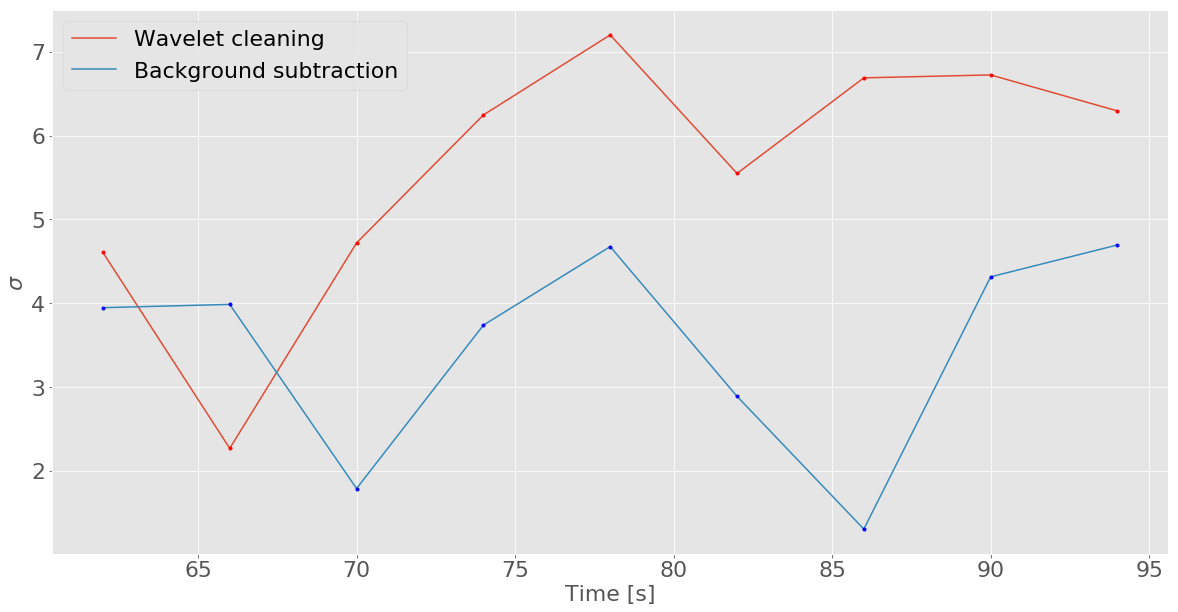

In [111]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(Tnew_max,WSignif,label='Wavelet cleaning')
ax.plot(Tnew_max,CSignif,label='Background subtraction')
ax.plot(Tnew_max,WSignif,'.',color='r')
ax.plot(Tnew_max,CSignif,'.',color='b')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('Time [s]',fontsize=22)
ax.set_ylabel('$\sigma$',fontsize=22)
#text = '%s\nIntensity factor =  : %s\n$(X_{Src},Y_{Src})$ = (%s,%s)'\
#                %(name,Speakval,xcenter,ycenter)
#ax.text(0.02,0.63,text, dict(size=12), transform = ax.transAxes,bbox=dict(facecolor='white', alpha=0.6))
ax.legend(fontsize=22)
plt.show()

# Performances

In [ ]:
# Fixing time range

cmd = '-N4 -f2 -F2 -n4  -T'
Niter = 20
Gauss_Sig = 0.35
WDistT,DistT = defaultdict(list),defaultdict(list)
WCubefile = output_dir + 'WavCube.fits'

for i in range(0,Niter):
    Cube,Cube_smoo,CubeW = {},{},{}
    Wxmax,Wymax,xmax,ymax = {},{},{},{}
    
    for Speakval in SrcPvalues:
        Bkgfile = output_dir + 'Bkgmodel_%s.fits'%(Speakval)
        BkgModel = Old_BkgModelCube(T_new[tmax],SteadySourcePeak,Bkg_input)
        smart.WriteCubeToFile(BkgModel,Bkgfile,'')

        Cubefile = output_dir + 'CubeSrc_P%s.fits'%(Speakval)
        Cube[Speakval] = ImageCube(LC_new[tmax],T_new[tmax],Speakval,xcenter,ycenter,SteadySourcePeak,Bkg_input)
        smart.WriteCubeToFile(Cube[Speakval],Cubefile,'')
        
        #CubeC = smart.CumulCube(Cube[Speakval])
        CubeClean = BkgSubCleaning(Cube[Speakval],BkgModel)
        #Cube_smoo[Speakval] = SmoothCleaning(CubeC,Gauss_Sig)
        
        CubeW[Speakval] = WavCleaning(Cubefile,WCubefile,Bkgfile,cmd)
            
        Wxmax[Speakval],Wymax[Speakval],Wtmax,WAmax,WLCtmax,WLCAmax = smart.get_peaks(CubeW[Speakval])
        xmax[Speakval],ymax[Speakval],Tmax,Amax,LCtmax,LCAmax = smart.get_peaks(CubeClean)
            
        WDistT[Speakval].append(ImageDistance(Wxmax[Speakval],Wymax[Speakval],xcenter,ycenter))
        DistT[Speakval].append(ImageDistance(xmax[Speakval],ymax[Speakval],xcenter,ycenter))
        #print(DistT)
    print(i+1,' done on ',Niter,end='\r')

In [ ]:
Valmin = 1
PerfT,PerfWT = [],[]
for Speakval in SrcPvalues:
    DistT[Speakval] = np.array(DistT[Speakval])
    WDistT[Speakval] = np.array(WDistT[Speakval])
    PerfT.append(\
        len(DistT[Speakval][np.where(DistT[Speakval]<=Valmin)])/len(DistT[Speakval]))
    PerfWT.append(\
        len(WDistT[Speakval][np.where(WDistT[Speakval]<=Valmin)])/len(WDistT[Speakval]))

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(SrcPvalues[:-1],PerfWT[:-1],ms=12,label='Wavelet method')
ax.plot(SrcPvalues[:-1],PerfT[:-1],ms=12,label='Bkg Cleaning')
ax.plot(SrcPvalues[:-1],PerfWT[:-1],'.',ms=12,color='r')
ax.plot(SrcPvalues[:-1],PerfT[:-1],'.',ms=12,color='b')
ax.set_ylabel('Position finding efficiency',fontsize=15)
ax.set_xlabel('Multiplicative factor of intensity',fontsize=15)
ax.set_xscale('log')
text = 'Theoretical light curve'
ax.text(0.02,0.8,text, dict(size=12), transform = ax.transAxes,bbox=dict(facecolor='white', alpha=0.6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Fixing Src peak value

cmd = '-N4 -f2 -F2 -n4 -T'
Niter = 10
Gauss_Sig = 0.35
WDistP,DistP = defaultdict(list),defaultdict(list)
WCubefile = output_dir + 'WavCube.fits'

for i in range(0,Niter):
    Cube,Cube_smoo,CubeW = {},{},{}
    Wxmax,Wymax,xmax,ymax = {},{},{},{}
    
    for T_max in Tnew_max:
        Cubefile = output_dir + 'CubeSrc_P%s.fits'%(Speak)
        Cube[T_max] = ImageCube(LC_new[tmax],T_new[tmax],Speak,xcenter,ycenter,SteadySourcePeak,Bkg_input)
        smart.WriteCubeToFile(Cube[T_max],Cubefile,'')
        
        CubeC = smart.CumulCube(Cube[T_max])
        Cube_smoo[T_max] = SmoothCleaning(CubeC,Gauss_Sig)
        
        CubeW[T_max] = WavCleaning(Cubefile,WCubefile,'',cmd)
            
        Wxmax[T_max],Wymax[T_max],Wtmax,WAmax,WLCtmax,WLCAmax = smart.get_peaks(CubeW[T_max])
        xmax[T_max],ymax[T_max],Tmax,Amax,LCtmax,LCAmax = smart.get_peaks(Cube_smoo[T_max])
            
        WDistP[T_max].append(ImageDistance(Wxmax[T_max],Wymax[T_max],xcenter,ycenter))
        DistP[T_max].append(ImageDistance(xmax[T_max],ymax[T_max],xcenter,ycenter))
    print(i+1,' done on ',Niter,end='\r')

In [ ]:
Valmin = 2
ScoreP,ScoreWP = [],[]
for T_max in Tnew_max:
    DistP[T_max] = np.array(DistP[T_max])
    WDistP[T_max] = np.array(WDistP[T_max])
    ScoreP.append(\
        len(DistP[T_max][np.where(DistP[T_max]<=Valmin)])/len(DistP[T_max]))
    ScoreWP.append(\
        len(WDistP[T_max][np.where(WDistP[T_max]<=Valmin)])/len(WDistP[T_max]))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(Tnew_max,ScoreWP,ms=12,label='Wavelet cleaning')
ax.plot(Tnew_max,ScoreP,ms=12,label='Convolve cleaning')
ax.set_ylabel('Position finding efficiency')
ax.set_xlabel('Time max')
#ax.set_xscale('log')
ax.legend()
plt.show()